In [1]:
#importing relevant libraries for the code
import pandas as pd
import numpy as np
from pandas.core.frame import DataFrame
import re
import os
import matplotlib as mpl
import matplotlib.pyplot as plt      
import math
import seaborn as sns
from collections import Counter
from matplotlib.pyplot import figure
import sklearn
from sklearn.preprocessing import LabelEncoder

In [2]:
#creating a copy of the df to work on and partially cleaning it
orig_df = pd.read_csv('SteamGamesDF.csv',index_col=0)
df = orig_df.copy() 
df.dropna(inplace=True) 
df.drop_duplicates(subset='Name',inplace=True,ignore_index=True)

In [3]:
#outlier detection func with iqr value on price col
def price_outlier_detection_iqr(df):
    temp_df = df.copy()
    outlier_rows = []
    Q1 = np.percentile(temp_df['Price'], 25)
    Q3 = np.percentile(temp_df['Price'], 75)
    IQR = Q3 - Q1
    IQR_range = 1.5 * IQR
    col_outlier = temp_df[(temp_df['Price'] < Q1 - IQR_range) | 
                        (temp_df['Price'] > Q3 + IQR_range)].index
    outlier_rows.extend(col_outlier)
    set(outlier_rows)
    for t in outlier_rows:
        temp_df.loc[t,'Price'] = np.nan
    return temp_df

In [4]:
#outlier detection func with z value on price col
#def outlier_detection_zscore_dist(df):
#    temp_df = df.copy()
#    z_score = (temp_df['Price'] - temp_df['Price'].mean()) / temp_df['Price'].std()
#    outliers = abs(z_score) > 3
#    temp_df.loc[outliers,'Price'] = np.nan
#    return temp_df

In [5]:
#running the outlier func on price col and cleaning data
df = price_outlier_detection_iqr(df)
df.dropna(inplace=True) 
df.drop_duplicates(subset='Name',inplace=True,ignore_index=True)

In [6]:
#func to clean the date col and add only years col
def cleandate_addyears(df):
    dateList = [] #list for new dates
    years = [] #list fo years
#switching months names strings with numbers
    for date in df['Date']:
        date = date.replace('Jan','1')
        date = date.replace('Feb','2')
        date = date.replace('Mar','3')
        date = date.replace('Apr','4')
        date = date.replace('May','5')
        date = date.replace('Jun','6')
        date = date.replace('Jul','7')
        date = date.replace('Aug','8')
        date = date.replace('Sep','9')
        date = date.replace('Oct','10')
        date = date.replace('Nov','11')
        date = date.replace('Dec','12')
        date = date.replace(' ','')
        date = date.replace(',','')
        dateList.append(date) #updating date column
    df['Date'] = dateList
    for date in df['Date']:
        years.append(date[-4:])
        #adding years col
    df['Date'] = df['Date'].astype(int)
    df['Year']=years
    df['Year'] = df['Year'].astype(int)
    return df

In [7]:
def AddNumGenresandHasMoreCol(df): #adding a col for the num of genres and a col for more than one (y/n)
    Genre = []
    Has_More_Than_One_Genre = []
    pattern = "'([A-Z]\w+\s*[A-Z]?\w*)',?"
    for i in df['Genre']:
        match = re.findall(pattern,i)
        Genre.append(match)
    
    Number_Of_Genres = []
    for L in Genre:
        Number_Of_Genres.append(len(L))

    df['Number_Of_Genres'] = Number_Of_Genres

    for L in Genre:
        if len(L)>1:
            Has_More_Than_One_Genre.append(1)
        else:
            Has_More_Than_One_Genre.append(0)

    df['More Than One Genre'] = Has_More_Than_One_Genre
    return df

In [8]:
def AddNumofLangs(df): #adding col for num of langs and a col for has other than english (y/n)
    Langs = []
    Has_Other_Than_English = []
    Number_Of_Langs = []
    pattern = "\'(\w+\s*\w*)\'?"
    for i in df['Langs']:
        match = re.findall(pattern,i)
        Langs.append(match)
    
    for L in Langs:
        Number_Of_Langs.append(len(L))
    
    df['Number of langs'] = Number_Of_Langs

    for L in Langs:
        if len(L)>1:
            Has_Other_Than_English.append(1)
        else:
            Has_Other_Than_English.append(0)

    df['Has Other Than English'] = Has_Other_Than_English
    return df

In [9]:
def SameDevAndPub(df): #adding a col for having the same developer and publisher (y/n)
    Same_Dev_Pub = []
    for i in range(df.shape[0]):
        if df.Developer[i] == df.Publisher[i]:
            Same_Dev_Pub.append(1)
        else:
            Same_Dev_Pub.append(0)
    df['Same Dev and Pub'] = Same_Dev_Pub
    return df

In [10]:
def ChangeToNumerical(df): #changing the cols to numerical values for trying to find corr
    col = ['Developer','Publisher','Genre','Langs']
    for i in col:
        df[i] = LabelEncoder().fit_transform(df[i])
    return df

In [11]:
def get_highly_correlated_cols(df): #trying to find corr in cols
    correlations = []
    tuple_arr = []
    df_p = df.corr(method='pearson')
    n_row = df_p.shape[0]
    n_col = df_p.shape[1]
    for i in range(n_row):
        for j in range(n_col):
            if(i==j):
                continue
            elif(df_p.iloc[i,j]>=0.5 or df_p.iloc[i,j]<=-0.5):
                if(df_p.iloc[i,j] in correlations):
                    continue
                else:
                    correlations.append(df_p.iloc[i,j])
                if(i<j):
                    temp_t = (i,j)
                else:
                    temp_t = (j,i)
                if(temp_t in tuple_arr):
                    continue
                else:
                    tuple_arr.append(temp_t)
    return correlations, tuple_arr

In [12]:
def get_types_of_genres(df): #getting diffrent types of genres for graph legend
    temp = df.copy()
    Genre = []
    pattern = "'([A-Z]\w+\s*[A-Z]?\w*)',?"
    for i in df['Genre']:
        match = re.findall(pattern,i)
        Genre.append(match)
    temp['Genre'] = Genre
    types = dict()
    for L in temp['Genre']:
        for T in L:
            if T in types:
                types[T] = types.get(T) + 1
            else:
               types.update({T:1}) 
    return types

In [13]:
def get_types_of_langs(df): #getting types of langs for graph legend
    temp = df.copy()
    Langs = []
    pattern = "\'(\w+\s*\w*)\'?"
    for i in df['Langs']:
        match = re.findall(pattern,i)
        Langs.append(match)
    temp['Langs'] = Langs
    types = dict()
    for L in temp['Langs']:
        for T in L:
            if T in types:
                types[T] = types.get(T) + 1
            else:
               types.update({T:1}) 
    return types

In [14]:
#running diffrent funcs on df
type_of_genres = get_types_of_genres(df)
type_of_langs = get_types_of_langs(df)
df = cleandate_addyears(df)
df = AddNumGenresandHasMoreCol(df)
df = AddNumofLangs(df)
df = SameDevAndPub(df)
df = ChangeToNumerical(df)
correlations,tuple_arr = get_highly_correlated_cols(df)

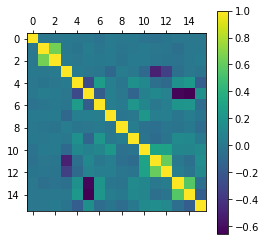

In [15]:
#trying to find corr with matrix and heat map
plt.matshow(df.corr())
plt.colorbar()
plt.show()
#print(df.corr()) #showing the same matrix numerical numbers

In [16]:
sr_price = df.value_counts(subset='Price')
sr_dlc = df.value_counts(subset='DLC')
sr_mat = df.value_counts(subset='Mature')
sr_single = df.value_counts(subset='Single')
sr_years = df.value_counts(subset='Year')
sr_multi_genre = df.value_counts(subset='More Than One Genre')
sr_multi_lang = df.value_counts(subset='Has Other Than English')
sr_same_devpub = df.value_counts(subset='Same Dev and Pub')

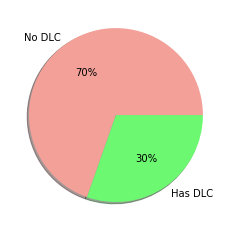

In [17]:
Colors = ['#F2A098','#6DF871']
plt.pie(sr_dlc,labels=["No DLC","Has DLC"],colors=Colors,shadow=True,autopct='%1.0f%%')
plt.show()

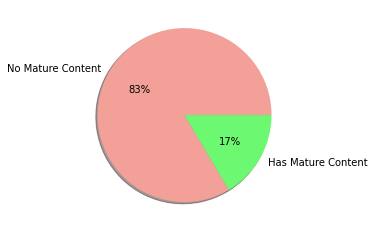

In [18]:
plt.pie(sr_mat,labels=["No Mature Content","Has Mature Content"],shadow=True,colors=Colors,autopct='%1.0f%%')
plt.show()

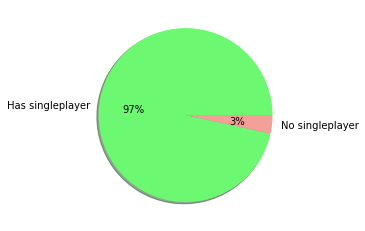

In [19]:
Colors = ['#6DF871','#F2A098']
plt.pie(sr_single,labels=["Has singleplayer","No singleplayer"],shadow=True,colors=Colors,autopct='%1.0f%%')
plt.show()

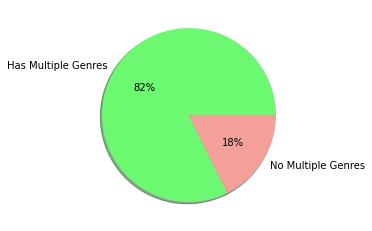

In [20]:
plt.pie(sr_multi_genre,labels=["Has Multiple Genres","No Multiple Genres"],colors=Colors,shadow=True,autopct='%1.0f%%')
plt.show()

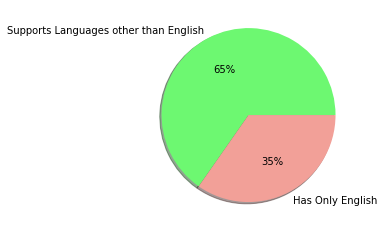

In [21]:
plt.pie(sr_multi_lang,labels=["Supports Languages other than English","Has Only English"],colors=Colors,shadow=True,autopct='%1.0f%%')
plt.show()

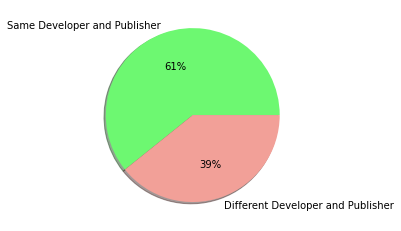

In [22]:
plt.pie(sr_same_devpub,labels=["Same Developer and Publisher","Different Developer and Publisher"],colors=Colors,shadow=True,autopct='%1.0f%%')
plt.show()

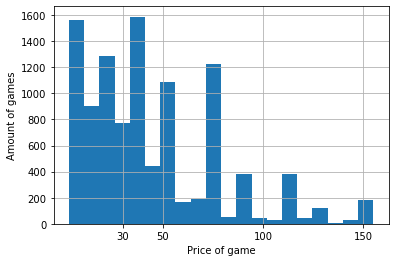

In [23]:
df.hist(column='Price',bins=20)
plt.xticks([30,50,100,150],['30','50','100','150'])
plt.xlabel('Price of game')
plt.ylabel('Amount of games')
plt.title(None)
plt.show()

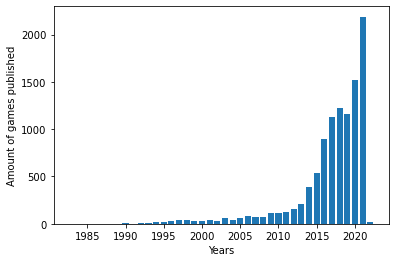

In [24]:
plt.bar(sr_years.keys(),sr_years.values)
plt.xlabel('Years')
plt.ylabel('Amount of games published')
plt.show()

In [25]:
sr_types_of_genres = pd.Series(type_of_genres)
sr_types_of_langs = pd.Series(type_of_langs)

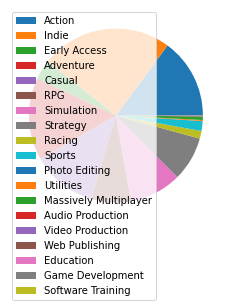

In [26]:
plt.pie(sr_types_of_genres)
plt.legend(labels=sr_types_of_genres.keys(),loc=2)
plt.show()

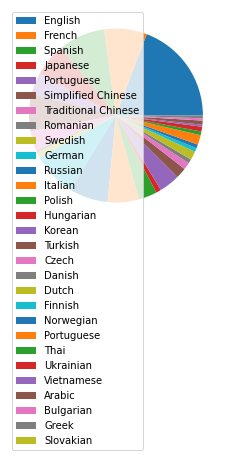

In [27]:
plt.pie(sr_types_of_langs)
plt.legend(labels=sr_types_of_langs.keys(),loc=2)
plt.show()